In [1]:
import os
import subprocess # We are using python 3.5 features! 

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
import earth_model

## Some Mineos wrapping stuff

Nothing much to see here - probably belongs in a module

In [3]:
MINEOS_BIN_FILE = '../cig/bin/minos_bran' # set for your setup!

def run_mineos(earth_model, model_name, mode_type, 
               lmin, lmax, wmin, wmax, nmin, nmax,
               eps=1E-10, wgrav=10, model_spacing=25):
    """
    Run Mineos
    
    Given a tabulated Earth model, set up a Mineos model file
    and a Mineos parameter file, and run the minos_bran code
    to compute mode frequencies, eigenvectors etc.
    
    Arguments:
    earth_model: an Earth model (e.g. a Prem instance)
    model_name: a string describing the name of the model
    mode_type: 'radial', 'toroidal', 'spheroidal' or 'inner_core_toroidal'
    lmin: minimum angular order
    lmax: maximum angular order
    wmin: minimum frequency (mHz)
    wmax: maximum frequency (mHz)
    nmin: minimum dispersion branch number
    nmax: maximim dispersion branch number
    eps: controls the accuracy of the Runge-Kutta integration scheme
    wgrav: the frequency in millihertz (mHz) above which gravitational
           terms are neglected
    model_spacing: maximum spacing (in km) used to represent the model
    """
    if mode_type == 'radial':
        code_letter = 'S' # this does l=0 spheroidal modes
        jcom = 1
    elif mode_type == 'toroidal':
        code_letter = 'T'
        jcom = 2
    elif mode_type == 'spheroidal':
        code_letter = 'S'
        jcom = 3
    elif mode_type == 'inner_core_toroidal':
        code_letter = 'T' # should I call this something else?
        jcom = 4
    else:
        raise ValueError("invalide mode type")
    
    name = 'mineos_run'
    param_file_name = name + '_param.txt'
    model_file_name = name + '_model.txt'
    text_output_file_name = name + '_text_out' + code_letter + '.txt'
    unformatted_output = name + 'eig_out' + code_letter + '.dat'
    
    # Tabulate and write out model
    table = prem.tabulate_model_outwards(model_spacing)
    write_mineos_model_file(table, model_file_name, model_name)
    
    # Run Mineos, piping in commands
    mineos = subprocess.Popen([MINEOS_BIN_FILE],
                              stdin=subprocess.PIPE,
                              universal_newlines=True,
                              bufsize=0)
    # Write param file
    mineos.stdin.write(model_file_name + "\n")
    mineos.stdin.write(text_output_file_name + "\n")
    mineos.stdin.write(unformatted_output + "\n")
    mineos.stdin.write("{} {}\n".format(eps, wgrav))
    mineos.stdin.write("{}\n".format(jcom))
    mineos.stdin.write("{} {} {} {} {} {}\n".format(lmin, lmax, 
                                                    wmin, wmax, 
                                                    nmin, nmax))
    mineos.stdin.close()
    mineos.wait()
    
    modes = read_mineos_mode_file(text_output_file_name)
    return modes

In [4]:
def write_mineos_model_file(table, mineos_model_filename, mineos_model_name):
    """
    Write out a formatter Mineos model
    """
    f = open(mineos_model_filename, 'w')
    f.write(mineos_model_name + "\n")
    f.write("   0    1.00000  1\n") # isotropic tabulated format 1s ref
    n = table.shape[0]
    nic = np.argwhere(table.vs==0)[0][0] # This is the last inner core index. 
    noc = np.argwhere(table.vs==0)[-1][0] + 1 # This is the last outer core index (assuming no ocean).
    f.write("{} {} {}\n".format(n, nic, noc))
    for r, rho, vp, vs, qk, qm in zip(table.radius, table.density, table.vp, table.vs, 
                              table.qkappa, table.qshear):
        f.write("{:#8.0f} {:#9.2f} {:#9.2f} {:#9.2f} {:#9.1f} {:#9.1f} {:#9.2f} {:#9.2f} {:#9.5f}\n".format(
                                                                   r*1000.0, rho, 
                                                                   vp*1000.0, vs*1000.0,
                                                                   qk, qm, vp*1000.0, vs*1000.0, 1.0))
    f.close()
    

In [5]:
def read_mineos_mode_file(filename):
    """
    Read output data from a Mineos run
    
    Returns results in dictionary with mode names as keys
    """
    read_modes = {}
    in_modes = False
    f = open(filename, 'r')
    for line in f:
        if not in_modes:
            words = line.split()
            if not words:
                # blank line
                continue
            elif words[0] == 'mode' and words[1] == 'phs':
                # One blank line then into the modes
                in_modes = True
        else:
            words = line.split()
            if not words:
                continue
            this_mode = {}
            n = words[0]
            letter = words[1].upper()
            l = words[2]
            this_mode['n'] = int(n)
            this_mode['type'] = letter
            this_mode['l'] = int(l)
            this_mode['phs_vel'] = float(words[3])
            this_mode['w'] = float(words[4])              
            this_mode['t'] = float(words[5])
            this_mode['grp_vel'] = float(words[6])
            this_mode['q'] = float(words[7])
            this_mode['raylquo'] = float(words[8])
            read_modes[n+letter+l] = this_mode
                
    return read_modes

## Setup and run a model with Mineos

And write in Mineos format

In [6]:
prem = earth_model.Prem()

In [7]:
s_modes = run_mineos(prem, 'a model name', mode_type='spheroidal', lmin=1, lmax=250, 
               wmin=0.0, wmax=166.0, nmin=0, nmax=10)

In [8]:
print("Mode 0S2 has period", s_modes['0S2']['t'], "and is 3233.115 secs in PREM Table V")

Mode 0S2 has period 3230.644 and is 3233.115 secs in PREM Table V


In [9]:
t_modes = run_mineos(prem, 'a model name', mode_type='toroidal', lmin=1, lmax=250, 
               wmin=0.0, wmax=166.0, nmin=0, nmax=10)

In [10]:
print("Mode 0T2 has period", t_modes['0T2']['t'], "and is 2636.38 secs in PREM Table V")


Mode 0T2 has period 2631.841 and is 2636.38 secs in PREM Table V


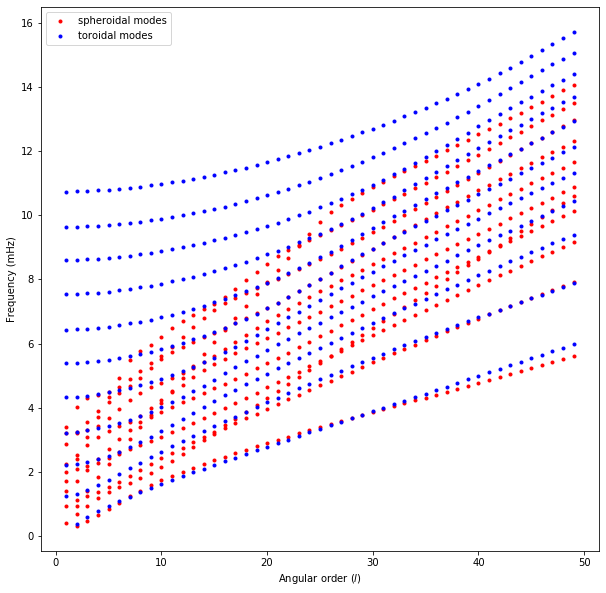

In [11]:
sls = []
sfs = []
for mode_name in s_modes:
    l = int(s_modes[mode_name]['l'])
    if l < 50:
        sls.append(l)
        sfs.append((1.0/s_modes[mode_name]['t'])*1E3)
    
tls = []
tfs = []
for mode_name in t_modes:
    l = int(t_modes[mode_name]['l'])
    if l < 50:
        tls.append(l)
        tfs.append((1.0/t_modes[mode_name]['t'])*1E3)    

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(sls, sfs, 'r.', label='spheroidal modes')
ax.plot(tls, tfs, 'b.', label='toroidal modes')

ax.set_xlabel('Angular order ($l$)')
ax.set_ylabel('Frequency (mHz)')
ax.legend()

plt.show()